## TO-DO
- Implement object detection
- Evaluation (metrics)

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import random
import matplotlib.pyplot as plt

from utils.loader import DataLoader
from models.effnet_encoder import EffnetEncoder
from models.mtl_framework import MTLFramework
from utils import tools, config

In [15]:
# Set configs
batch_size = 16
batch_size_val = 16
num_train, num_val, num_test = config.config['num_train'], config.config['num_val'], config.config['num_test']
img_height, img_width, channels = config.config['input_shape']

In [16]:
# Load our data pipeline
loader = DataLoader(batch_size=batch_size, batch_size_val=batch_size_val)

# Train set
img_ds = loader.get_image_ds().repeat()
masks_ds = loader.get_mask_ds().repeat()
label_ds = loader.get_binary_ds().repeat()
bbox_ds = loader.get_bboxes_ds().repeat()

# Validation set
img_ds_val = loader.get_image_ds(val=True).repeat()
masks_ds_val = loader.get_mask_ds(val=True).repeat()
label_ds_val = loader.get_binary_ds(val=True).repeat()
bbox_ds_val = loader.get_bboxes_ds(val=True).repeat()

Plot some examples (Ignore if training)

In [5]:
# Make some examples
examples = tf.data.Dataset.zip((img_ds, masks_ds, bbox_ds)).as_numpy_iterator()
display_list = next(examples)

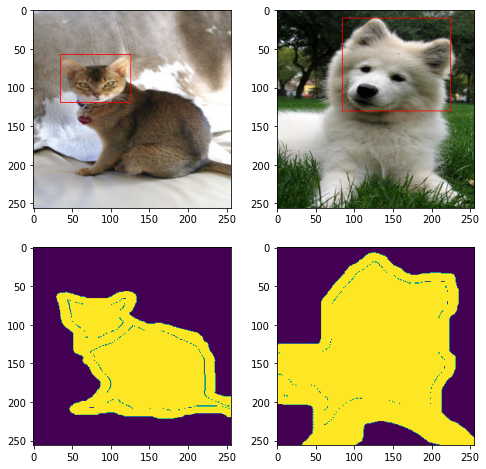

In [11]:
# View some examples
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(8,8))
for i in range(2):
    box_img = tf.image.draw_bounding_boxes(tf.expand_dims(display_list[0][i,...], 0), tools.fix_bbox(display_list[2][i]).reshape([1,1,4])/256, np.array([[255, 0, 0]]))
    ax1[i].imshow(tf.keras.utils.array_to_img(tf.squeeze(box_img)))
    ax2[i].imshow((display_list[1][i,...]))

Build our MTL

In [7]:
# Get encoder
base_model_name = 'B0'
encoder = EffnetEncoder(base_model_name, (img_height, img_width, channels)).build_encoder(trainable=False)


In [ ]:
encoder.summary()

In [17]:
# Use our MTL framework to build a model
mtl_builder = MTLFramework(encoder, (img_height, img_width, channels))
mtl_builder.add_segmentation_head()
mtl_builder.add_binary_classification_head(base_model_name, trainable=False)
model = mtl_builder.build_mtl_model()

In [ ]:
model.summary()

Train model

In [5]:
def generator_img():
    ''' Merges together datasets into a unified generator to pass for training '''
    a = img_ds.as_numpy_iterator()
    b = masks_ds.as_numpy_iterator()
    c = label_ds.as_numpy_iterator()
    
    while True:
        X = a.next()
        Y1 = b.next()
        Y2 = c.next()
        
        # Regularisation and shuffling
        X, Y1, Y2 = tools.get_randomised_data([X, Y1, Y2])
        X, Y1 = tools.data_augmentation(X, Y1)
        
        yield X, (Y1, Y2)

In [13]:
def generator_img_val():
    ''' Merges together datasets into a unified generator to pass for training '''
    a = img_ds_val.as_numpy_iterator()
    b = masks_ds_val.as_numpy_iterator()
    c = label_ds_val.as_numpy_iterator()
    
    while True:
        X = a.next()
        Y1 = b.next()
        Y2 = c.next()
        
        yield X, (Y1, Y2)

In [18]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss={'segnet_out' : tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    'bin_class_out' : tf.keras.losses.BinaryCrossentropy()},
              metrics=['accuracy'])

In [19]:
model.fit(generator_img(), validation_data=generator_img_val(), epochs=10, steps_per_epoch=num_train//batch_size, validation_steps=num_val//batch_size_val)

Epoch 1/10
138/138 [==============================] - 84s 578ms/step - loss: 0.5316 - segnet_out_loss: 0.2443 - bin_class_out_loss: 0.2873 - segnet_out_accuracy: 0.8954 - bin_class_out_accuracy: 0.9230 - val_loss: 0.2899 - val_segnet_out_loss: 0.1954 - val_bin_class_out_loss: 0.0946 - val_segnet_out_accuracy: 0.9390 - val_bin_class_out_accuracy: 0.9932
Epoch 2/10
138/138 [==============================] - 89s 650ms/step - loss: 0.2643 - segnet_out_loss: 0.1538 - bin_class_out_loss: 0.1105 - segnet_out_accuracy: 0.9400 - bin_class_out_accuracy: 0.9774 - val_loss: 0.1881 - val_segnet_out_loss: 0.1412 - val_bin_class_out_loss: 0.0469 - val_segnet_out_accuracy: 0.9496 - val_bin_class_out_accuracy: 0.9946
Epoch 3/10
138/138 [==============================] - 73s 531ms/step - loss: 0.2250 - segnet_out_loss: 0.1452 - bin_class_out_loss: 0.0798 - segnet_out_accuracy: 0.9425 - bin_class_out_accuracy: 0.9792 - val_loss: 0.1655 - val_segnet_out_loss: 0.1335 - val_bin_class_out_loss: 0.0320 - val_

KeyboardInterrupt: 

## Test out model

In [14]:
b = generator_img()
a = next(b)
i = 0

In [18]:
def show_seg_pred(img: np.array, mask_truth: np.array, mask_pred: np.array):
    ''' Show segmentation prediction '''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,12))
    seg_max = tf.where(mask_pred > 0, 1, 0)
    ax1.imshow(tf.keras.utils.array_to_img(tf.squeeze(img)))
    ax2.imshow(tf.keras.utils.array_to_img(mask_truth))
    ax3.imshow(tf.keras.utils.array_to_img(seg_max[0]))

In [ ]:
seg_pred, bin_pred = model.predict(a[0][i][tf.newaxis,...])
tools.show_seg_pred(a[0][i,...], a[1][0][i,...], seg_pred)
print(f'Dog: {1-bin_pred[0]},   Cat: {bin_pred[0]}') # 0 is dog, 1 is cat
i += 1

## Test on test-set

In [26]:
img_ds_test = loader.get_image_ds(test_mode=True)
masks_ds_test = loader.get_mask_ds(test_mode=True)
label_ds_test = loader.get_binary_ds(test_mode=True)
#bbox_ds_test = loader.get_bboxes_ds(test=True)

In [ ]:
img_ds_test = tf.data.Dataset(img_ds_test)

In [39]:
# Predict on test-set
segPred = []
binPred = []

for i in range(len(img_ds_test)):
    seg_pred, bin_pred = model.predict(img_ds_test[i][tf.newaxis, ...])
    seg_pred = tf.where(seg_pred > 0, 1, 0)
    bin_pred = np.round(bin_pred)
    segPred.append([segPred])
    binPred.append([bin_pred])

binPred = np.array(binPred)
segPred = np.array(segPred)
bin_acc = np.sum(np.round(binPred) == label_ds_test)/label_ds_test.shape[0]
seg_acc = np.sum(segPred == masks_ds_test)/(masks_ds_test.shape[0]*(img_height*img_width))
print(f'Binary Acc: {round(bin_acc*100, 3)}%,   Seg Acc: {round(seg_acc*100, 3)}%')